In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
train_path = '/content/data/train.csv'
test_path = '/content/data/test.csv'
#xieyuan那边处理之后的结果
train_newmake_path = '/content/data/train_newmake.csv'
train_processed_path = '/content/data/train_processed.csv'
test_processed_path = '/content/data/test_processed.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_train_newmake = pd.read_csv(train_newmake_path)
df_train_processed = pd.read_csv(train_processed_path)#相比于newmake，填补了power以及增加了coe month left
df_test_processed = pd.read_csv(test_processed_path)

In [2]:
features = ['make' , 'model' , 'manufactured'	, 'reg_date', 'type_of_vehicle' ,'category','transmission','curb_weight','power',
                      'engine_cap','no_of_owners','depreciation','coe','road_tax','dereg_value','mileage','omv','arf','price']
df = df_train_newmake[features].copy()

In [3]:
missing_values = df.isnull().sum()
print('number of missing values in each feature')
print(missing_values)

number of missing values in each feature
make                  0
model                 0
manufactured          7
reg_date              0
type_of_vehicle       0
category              0
transmission          0
curb_weight         307
power              2640
engine_cap          596
no_of_owners         18
depreciation        507
coe                   0
road_tax           2632
dereg_value         220
mileage            5304
omv                  64
arf                 174
price                 0
dtype: int64


In [4]:
features_1 = ['make' , 'model' , 'manufactured'	, 'reg_date', 'type_of_vehicle' ,'category','transmission','curb_weight','power',
                      'engine_cap','no_of_owners','depreciation','coe','road_tax','dereg_value','mileage','omv','arf','price','car_age','coe_month_left']
df_1 = df_train_processed[features_1].copy()
missing_values = df_1.isnull().sum()
print('number of missing values in each feature')
print(missing_values)

number of missing values in each feature
make                  0
model                 0
manufactured          7
reg_date              0
type_of_vehicle       0
category              0
transmission          0
curb_weight         307
power                 0
engine_cap          596
no_of_owners         18
depreciation        507
coe                   0
road_tax           2632
dereg_value         220
mileage            5304
omv                  64
arf                 174
price                 0
car_age               0
coe_month_left        1
dtype: int64


In [5]:
power_stats = df.groupby(['make', 'model'])['power'].agg(['mean', 'min', 'max', 'count']).reset_index()
power_stats['difference'] = power_stats['max'] - power_stats['min']
# 找出差值最大的前十个类别
top_10_diff = power_stats.nlargest(10, 'difference')
print('差值最大的十个类别\n',top_10_diff)
selected_columns_campare = ['price','power']
correlation_matrix = df[selected_columns_campare].corr()
print('相关性\n',correlation_matrix)

差值最大的十个类别
               make         model        mean    min    max  count  difference
562  mercedes-benz           amg  229.632479   90.0  484.0    117       394.0
825        porsche        taycan  351.029412  240.0  525.0     34       285.0
472     land rover   range rover  218.471074  132.0  415.0    121       283.0
414         jaguar        f-pace  218.862069  132.0  405.0     29       273.0
468     land rover  defender 110  222.866667   44.0  307.0     15       263.0
915          tesla       model 3  292.156250  208.0  461.0     64       253.0
949         toyota  land cruiser  231.363636   60.0  305.0     11       245.0
217            byd          seal  230.000000  150.0  390.0      8       240.0
4       alfa romeo        giulia  274.555556  147.0  375.0      9       228.0
9       alfa romeo       stelvio  295.800000  148.0  375.0      5       227.0
相关性
           price     power
price  1.000000  0.703498
power  0.703498  1.000000


In [6]:
selected_columns_campare = ['price','power','engine_cap','road_tax','mileage']
correlation_matrix = df[selected_columns_campare].corr()
print('相关性\n',correlation_matrix)

相关性
                price     power  engine_cap  road_tax   mileage
price       1.000000  0.703498    0.443110  0.527713 -0.392547
power       0.703498  1.000000    0.865975  0.822907 -0.230732
engine_cap  0.443110  0.865975    1.000000  0.946788 -0.035450
road_tax    0.527713  0.822907    0.946788  1.000000 -0.051804
mileage    -0.392547 -0.230732   -0.035450 -0.051804  1.000000


In [7]:
#更新coe以及计算leftmonth_depre
rows = df_1['car_age']<10
df_1.loc[rows, 'coe_month_left'] = (10 - df_1.loc[rows, 'car_age'])*12

In [8]:
leftmonth_depre=df_1['coe_month_left']*df_1['depreciation']/12
df_1['leftmonth_depre'] = leftmonth_depre

df_1.loc[rows, 'leftmonth_depre'] = df_1.loc[rows, 'leftmonth_depre'] + df_1.loc[rows, 'arf']/2
df_1['leftmonth_depre'] = df_1['leftmonth_depre'].round(1)

In [9]:
rows = df_test_processed['car_age']<10
df_test_processed.loc[rows, 'coe_month_left'] = (10 - df_test_processed.loc[rows, 'car_age'])*12
leftmonth_depre_test=df_test_processed['coe_month_left']*df_test_processed['depreciation']/12
df_test_processed['leftmonth_depre'] = leftmonth_depre_test

df_test_processed.loc[rows, 'leftmonth_depre'] = df_test_processed.loc[rows, 'leftmonth_depre'] + df_test_processed.loc[rows, 'arf']/2
df_test_processed['leftmonth_depre'] = df_test_processed['leftmonth_depre'].round(1)

In [10]:
mean_absolute_error = (df_1['price'] - df_1['leftmonth_depre']).abs().mean()
print(mean_absolute_error)
print(np.sqrt(((df_1['price'] - df_1['leftmonth_depre'])**2).mean()))

4060.3145256431267
11812.92053424679


In [11]:
display(df_1[['make','model','reg_date','car_age','coe_month_left','leftmonth_depre','price']].head(10))

,make,model,reg_date,car_age,coe_month_left,leftmonth_depre,price
0,land rover,range rover,2018-03-08,6.49,42.12,186303.2,193788.0
1,mercedes-benz,c200,2017-12-28,6.68,39.84,92259.4,96800.0
2,honda,odyssey,2007-09-19,16.96,38.14,39792.7,39800.0
3,toyota,corolla altis,2008-12-15,15.72,53.03,44810.4,44800.0
4,lexus,gs300,2006-12-22,17.71,22.62,25805.6,25800.0
5,honda,s2000,2008-11-06,15.83,50.86,170889.6,170888.0
6,lamborghini,huracan,2022-05-13,2.31,92.28,1337427.7,1368000.0
7,hyundai,avante,2010-01-26,14.61,10.98,NaN,5350.0
8,mercedes-benz,c200,2017-11-28,6.76,38.88,97718.8,102500.0
9,mitsubishi,evolution,2009-03-05,15.50,54.64,124989.0,125000.0


<ipython-input-12-15321f19320b>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_per_year = df_1_new.groupby('manufactured').apply(


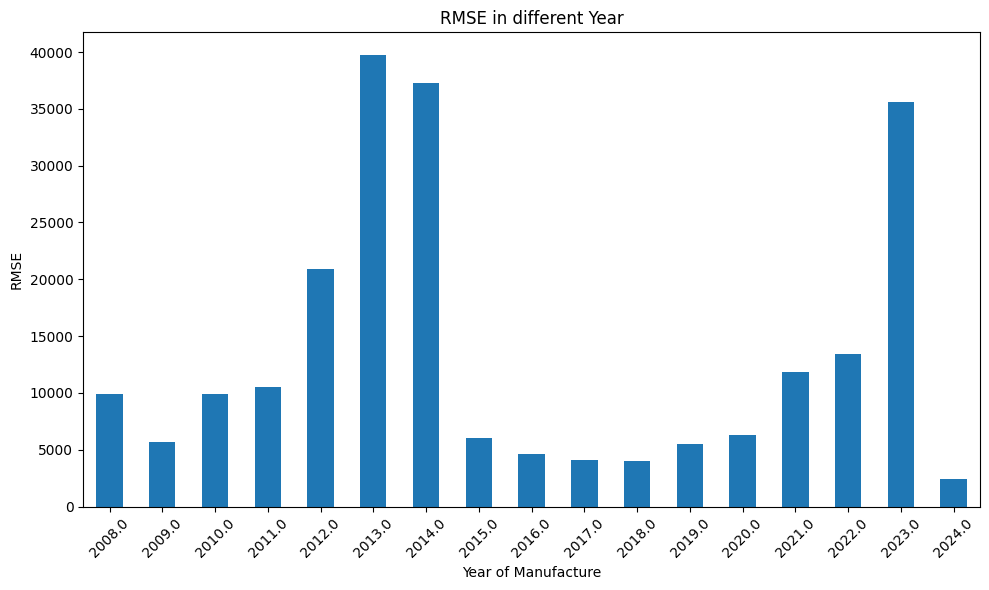

In [12]:
df_1_new = df_1[df['manufactured']>=2008]
rmse_per_year = df_1_new.groupby('manufactured').apply(
    lambda x: np.sqrt(((x['price'] - x['leftmonth_depre']) ** 2).mean())
).rename('RMSE')

# 绘制柱状图
plt.figure(figsize=(10, 6))
rmse_per_year.plot(kind='bar')
plt.title("RMSE in different Year")
plt.xlabel("Year of Manufacture")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
df_1 = df_1.dropna(subset=['manufactured','leftmonth_depre'])

In [14]:
submission_path = '/content/data/submission.csv'

df_submission = pd.read_csv(submission_path)

In [15]:
missing_values = df_test.isnull().sum()
print(missing_values)

listing_id               0
title                    0
make                   541
model                    0
description            268
manufactured             3
original_reg_date     9903
reg_date                 0
type_of_vehicle          0
category                 0
transmission             0
curb_weight            110
power                 1086
fuel_type             7650
engine_cap             235
no_of_owners             8
depreciation           201
coe                      0
road_tax              1082
dereg_value             83
mileage               2166
omv                     29
arf                     65
opc_scheme            9953
lifespan              9026
eco_category             0
features               323
accessories           1566
indicative_price     10000
dtype: int64


In [16]:
display(df_1[['manufactured','dereg_value','coe','omv','car_age','arf','manufactured','depreciation','coe_month_left','leftmonth_depre','price']].head(5))

,manufactured,dereg_value,coe,omv,car_age,arf,manufactured,depreciation,coe_month_left,leftmonth_depre,price
0,2018.0,103323.0,48011.0,88906.0,6.49,132031.0,2018.0,34270.0,42.12,186303.2,193788.0
1,2017.0,45179.0,47002.0,40678.0,6.68,43950.0,2017.0,21170.0,39.84,92259.4,96800.0
2,2007.0,16003.0,50355.0,27994.0,16.96,30794.0,2007.0,12520.0,38.14,39792.7,39800.0
3,2008.0,12184.0,27571.0,16084.0,15.72,16084.0,2008.0,10140.0,53.03,44810.4,44800.0
4,2006.0,9138.0,48479.0,50414.0,17.71,55456.0,2006.0,13690.0,22.62,25805.6,25800.0


In [17]:
PARF_rate = {
    '<5': 0.75,
    '5<age<6': 0.7,
    '6<age<7': 0.65,
    '7<age<8': 0.6,
    '8<age<9': 0.55,
    '9<age<10': 0.5,
    '10<age<11': 0
}

In [18]:
rows = df_test_processed['car_age']<10
df_test_processed.loc[rows, 'coe_month_left'] = (10 - df_test_processed.loc[rows, 'car_age'])*12
leftmonth_depre_test=df_test_processed['coe_month_left']*df_test_processed['depreciation']/12
df_test_processed['leftmonth_depre'] = leftmonth_depre_test

df_test_processed.loc[rows, 'leftmonth_depre'] = df_test_processed.loc[rows, 'leftmonth_depre'] + df_test_processed.loc[rows, 'arf']/2
df_test_processed['leftmonth_depre'] = df_test_processed['leftmonth_depre'].round(1)

In [19]:
rows_both_missing = df_test_processed[df_test_processed['leftmonth_depre'].isnull() ]
print(rows_both_missing)

Empty DataFrame
Columns: [listing_id, title, make.bak, model.bak, description, manufactured, original_reg_date, reg_date, type_of_vehicle, category, transmission, curb_weight, power, fuel_type, engine_cap, no_of_owners, depreciation, coe, road_tax, dereg_value, mileage, omv, arf, opc_scheme, lifespan, eco_category, features, accessories, indicative_price, make, model, coe_month_left, car_age, calculated_price, leftmonth_depre]
Index: []

[0 rows x 35 columns]


In [20]:
print(df_submission['Predicted'])
print(df_test_processed['leftmonth_depre'])

0        34981.929326
1        51167.326079
2       160660.603169
3        91714.683707
4        45752.908469
            ...      
9995    127523.546579
9996    200557.272195
9997     89986.969483
9998    100851.911021
9999     70944.801954
Name: Predicted, Length: 10000, dtype: float64
0        15563.7
1        33670.0
2       146228.1
3        73272.5
4        23292.7
          ...   
9995    114208.3
9996    199335.7
9997     72360.0
9998     82310.7
9999     53149.2
Name: leftmonth_depre, Length: 10000, dtype: float64


In [21]:
#find rows with missing value
missing_indices = df_test['depreciation'].isnull()
df_test_processed.loc[missing_indices, 'leftmonth_depre'] = df_submission.loc[missing_indices, 'Predicted']

In [22]:
indices = df_test_processed[(df_test_processed['manufactured'].between(2012, 2014)) | (df_test_processed['manufactured'] == 2023)].index

df_test_processed.loc[indices, 'leftmonth_depre'] = df_submission.loc[indices, 'Predicted']

In [23]:
df_output = pd.DataFrame({
    'Id': df_test_processed.index,
    'Predicted': df_test_processed['leftmonth_depre']
})

# save
df_output.to_csv('output.csv', index=False)

In [24]:
df_1 = df_1.drop(columns=['reg_date', 'road_tax', 'mileage'])
df_1.columns

Index(['make', 'model', 'manufactured', 'type_of_vehicle', 'category',
       'transmission', 'curb_weight', 'power', 'engine_cap', 'no_of_owners',
       'depreciation', 'coe', 'dereg_value', 'omv', 'arf', 'price', 'car_age',
       'coe_month_left', 'leftmonth_depre'],
      dtype='object')

Here is an exploration of applying different data mining methods to the dataset in the first phase. Note that these results are based on a preliminarily processed dataset, with certain features selected and some missing values directly discarded. The main objective here is to explore the differences in effectiveness among various data mining methods, providing direction for more in-depth research on specific methods in the future.

From the results here, we found that the performance of MLP and linear regression was generally subpar, so these two models were not further explored in subsequent analyses.


In [25]:
df_1 = df_1.dropna()
print(df_1.shape)

(23509, 19)


In [26]:
#categorical = ['make', 'model','type_of_vehicle','category','transmission']
categorical = ['make', 'model','type_of_vehicle','category']
#unique_counts = df_clean[categorical].nunique()
unique_counts = df_1[categorical].nunique()

print(unique_counts)

make                75
model              724
type_of_vehicle     11
category           173
dtype: int64


In [27]:
#numerical = ['manufactured', 'curb_weight', 'power', 'engine_cap', 'no_of_owners','depreciation', 'dereg_value', 'omv', 'arf', 'year', 'de/coe']
numerical = ['car_age' ,'coe_month_left',
       'curb_weight', 'power', 'engine_cap', 'no_of_owners',
       'depreciation', 'dereg_value', 'omv', 'arf']

In [28]:
'''
df_2 =df_1[['make', 'model', 'car_age' ,'coe_month_left', 'type_of_vehicle',
        'power', 'engine_cap','omv', 'arf','depreciation',
        'dereg_value','price']].copy()
       #'no_of_owners','curb_weight',
df_2.dropna(inplace=True)
'''
df_2 = df_1
feature_choose = categorical+numerical
x = df_2[feature_choose].copy()
y = df_2['price'].copy()

print(x.shape)
x.columns

(23509, 14)


Index(['make', 'model', 'type_of_vehicle', 'category', 'car_age',
       'coe_month_left', 'curb_weight', 'power', 'engine_cap', 'no_of_owners',
       'depreciation', 'dereg_value', 'omv', 'arf'],
      dtype='object')

In [29]:
#decision tree and random forest
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
x_1 = x.copy()
y_1 = y.copy()
#  Label Encoding for categorical feature
label_encoders = {}
for col in categorical:
    le = LabelEncoder()
    x_1[col] = le.fit_transform(x_1[col])
    label_encoders[col] = le
x_train, x_test, y_train, y_test = train_test_split(x_1, y_1, test_size=0.2, random_state=100)

In [30]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error


tree_model = DecisionTreeRegressor(max_depth=13,random_state=42)


tree_model.fit(x_train, y_train)


y_pred_tree = tree_model.predict(x_test)

rmse_tree = mean_squared_error(y_test, y_pred_tree, squared=False)
print(f"Decision Tree RMSE: {rmse_tree}")
r2_tree = r2_score(y_test, y_pred_tree)
print(f"Decision Tree R² Score: {r2_tree}")


Decision Tree RMSE: 20496.370989323023
Decision Tree R² Score: 0.9794258818579461


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


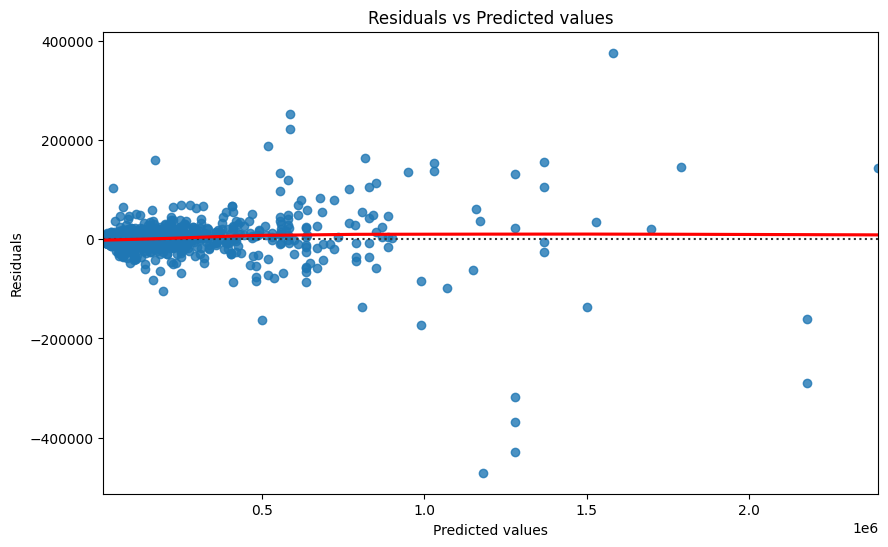

In [31]:

y_test_np = np.array(y_test)
y_pred_np = np.array(y_pred_tree)

residuals = y_test_np - y_pred_np

plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred_tree, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted values")
plt.show()

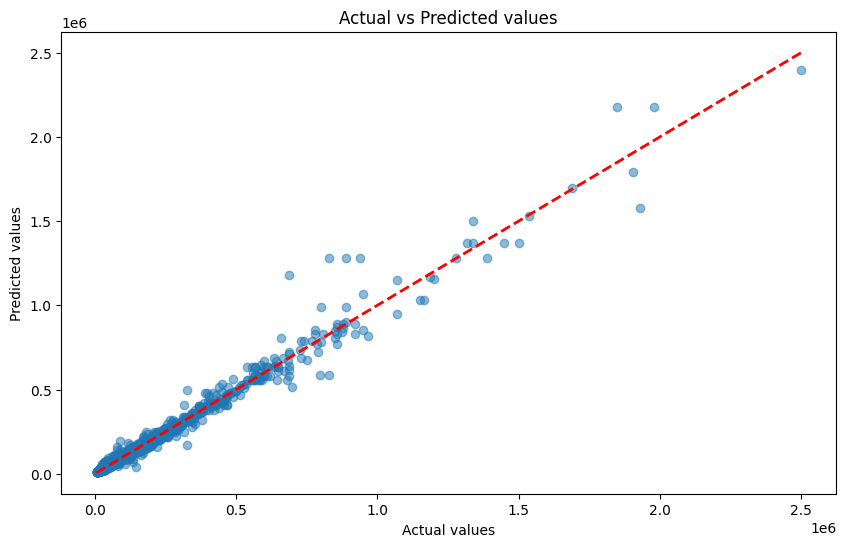

In [32]:
# Actual values vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_tree, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted values')
plt.show()

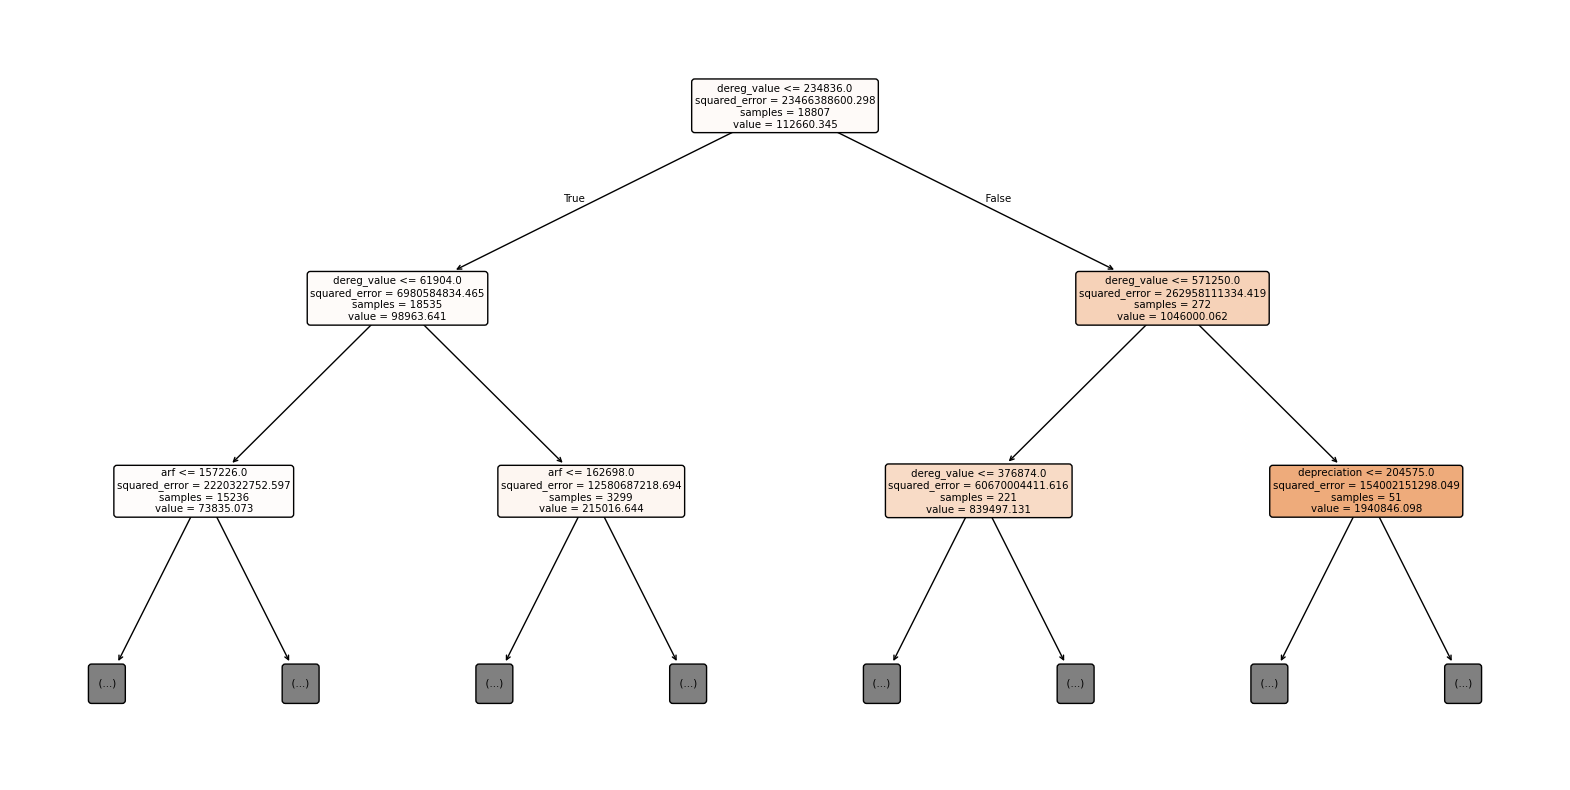

In [33]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


plt.figure(figsize=(20,10))

plot_tree(tree_model, max_depth=2,filled=True, feature_names=x_train.columns, rounded=True)
plt.show()


In [34]:
for pred, actual in zip(y_pred_tree[:10], y_test[:10]):
    print(f"Predicted: {pred}, Actual: {actual}")

Predicted: 144844.4411764706, Actual: 148000.0
Predicted: 258800.0, Actual: 258800.0
Predicted: 24714.82075471698, Actual: 21500.0
Predicted: 406800.0, Actual: 468800.0
Predicted: 36288.66055045871, Actual: 35800.0
Predicted: 36288.66055045871, Actual: 34800.0
Predicted: 104200.07692307692, Actual: 100800.0
Predicted: 57580.97297297297, Actual: 59588.0
Predicted: 179585.5, Actual: 178800.0
Predicted: 111016.58333333333, Actual: 114800.0


In [35]:
print(f"Tree depth: {tree_model.get_depth()}")

Tree depth: 13


In [36]:
from sklearn.ensemble import RandomForestRegressor

forest_model = RandomForestRegressor(n_estimators=500,max_depth=20, random_state=42)

forest_model.fit(x_train, y_train)
y_pred_forest = forest_model.predict(x_test)
mse_forest = mean_squared_error(y_test, y_pred_forest)
print(f"Random Forest Mean Squared Error: {mse_forest}")
rmse_forest = mean_squared_error(y_test, y_pred_forest, squared=False)
print(f"Decision Tree RMSE: {rmse_forest}")
r2_forest = r2_score(y_test, y_pred_forest)
print(f"Random Forest R² Score: {r2_forest}")

Random Forest Mean Squared Error: 203790494.02669394
Decision Tree RMSE: 14275.520797039033
Random Forest R² Score: 0.9900195251442355


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [37]:
for pred, actual in zip(y_pred_forest[:10], y_test[:10]):
    print(f"Predicted: {pred}, Actual: {actual}")

Predicted: 146172.66553160027, Actual: 148000.0
Predicted: 256848.78366666666, Actual: 258800.0
Predicted: 21717.850639730943, Actual: 21500.0
Predicted: 543860.952, Actual: 468800.0
Predicted: 35465.02228410041, Actual: 35800.0
Predicted: 34193.19830586733, Actual: 34800.0
Predicted: 100585.63595266412, Actual: 100800.0
Predicted: 59450.51511428573, Actual: 59588.0
Predicted: 181366.8202522144, Actual: 178800.0
Predicted: 113865.43128404237, Actual: 114800.0


In [38]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
x_2 = x.copy()
y_2 = y.copy()
categorical_cols = ['type_of_vehicle','make']
x_categorical = x_2[categorical_cols]
# OneHotEncoder
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False)  # drop='first' to avoid multicollinearity
x_one_hot_encoded = one_hot_encoder.fit_transform(x_categorical)


encoded_cols = one_hot_encoder.get_feature_names_out(categorical_cols)
x_one_hot_df = pd.DataFrame(x_one_hot_encoded, columns=encoded_cols)
display(x_one_hot_df)

,type_of_vehicle_hatchback,type_of_vehicle_luxury sedan,type_of_vehicle_mid-sized sedan,type_of_vehicle_mpv,type_of_vehicle_others,type_of_vehicle_sports car,type_of_vehicle_stationwagon,type_of_vehicle_suv,type_of_vehicle_truck,type_of_vehicle_van,...,make_subaru,make_suzuki,make_td,make_toyota,make_triumph,make_ud,make_valiant,make_volkswagen,make_volvo,make_yutong
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23504,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23505,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23506,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23507,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.2 MB/s eta 0:00:00


In [40]:
import category_encoders as ce

# Target Encoding for high-cardinality categorical features
target_encoder = ce.TargetEncoder(cols=['model', 'category'])
x_encoded = target_encoder.fit_transform(x_2, y_2)
display(x_encoded)

,make,model,type_of_vehicle,category,car_age,coe_month_left,curb_weight,power,engine_cap,no_of_owners,depreciation,dereg_value,omv,arf
0,land rover,195127.605240,suv,81229.486769,6.49,42.12,1884.0,280.0,2995.0,2.0,34270.0,103323.0,88906.0,132031.0
1,mercedes-benz,106565.472653,luxury sedan,88014.114082,6.68,39.84,1465.0,135.0,1991.0,2.0,21170.0,45179.0,40678.0,43950.0
2,honda,82599.009092,mpv,100984.125485,16.96,38.14,1648.0,118.0,2354.0,3.0,12520.0,16003.0,27994.0,30794.0
3,toyota,55953.602151,mid-sized sedan,76054.620284,15.72,53.03,1195.0,80.0,1598.0,3.0,10140.0,12184.0,16084.0,16084.0
4,lexus,86161.645991,luxury sedan,76054.620284,17.71,22.62,1660.0,183.0,2995.0,6.0,13690.0,9138.0,50414.0,55456.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24994,honda,75457.519270,mid-sized sedan,88014.114082,5.19,57.72,1237.0,92.0,1597.0,1.0,15560.0,31900.0,20031.0,20044.0
24995,mercedes-benz,93782.235023,luxury sedan,100984.125485,13.15,81.96,1500.0,115.0,1597.0,2.0,12440.0,30921.0,31019.0,31019.0
24997,mercedes-benz,79425.192966,hatchback,94131.460294,9.43,6.84,1395.0,90.0,1595.0,2.0,21290.0,11890.0,22897.0,14056.0
24998,audi,73048.038988,hatchback,81229.486769,7.18,33.84,1275.0,85.0,999.0,2.0,15010.0,24070.0,23772.0,15281.0


In [41]:
selected_columns_campare = ['model','category']
correlation_matrix = pd.concat([x_encoded[selected_columns_campare],y_2],axis=1).corr()
print('相关性\n',correlation_matrix)

相关性
              model  category     price
model     1.000000  0.579326  0.783961
category  0.579326  1.000000  0.691519
price     0.783961  0.691519  1.000000


In [42]:
from sklearn.preprocessing import StandardScaler

numerical_cols = numerical
x_numerical_and_target_encoded = pd.concat([x_2[numerical_cols], x_encoded[['model', 'category']]], axis=1)

scaler = StandardScaler()
x_standardized = scaler.fit_transform(x_numerical_and_target_encoded)

x_standardized_df = pd.DataFrame(x_standardized, columns=numerical_cols + ['model', 'category'])


x_final = pd.concat([x_one_hot_df.reset_index(drop=True), x_standardized_df.reset_index(drop=True)], axis=1)
display(x_final)

,type_of_vehicle_hatchback,type_of_vehicle_luxury sedan,type_of_vehicle_mid-sized sedan,type_of_vehicle_mpv,type_of_vehicle_others,type_of_vehicle_sports car,type_of_vehicle_stationwagon,type_of_vehicle_suv,type_of_vehicle_truck,type_of_vehicle_van,...,curb_weight,power,engine_cap,no_of_owners,depreciation,dereg_value,omv,arf,model,category
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.395661,1.820632,0.916384,-0.184325,0.709443,0.938232,0.994732,1.123491,1.155024,-0.286681
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.124622,-0.068156,-0.048543,-0.184325,0.039220,-0.008836,-0.003310,-0.001567,0.033957,-0.216639
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.102614,-0.289600,0.300330,0.502301,-0.403332,-0.484064,-0.265796,-0.169609,-0.269423,-0.082742
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.459888,-0.784593,-0.426248,0.502301,-0.525098,-0.546270,-0.512265,-0.357500,-0.606714,-0.340105
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.117515,0.557098,0.916384,2.562178,-0.343472,-0.595884,0.198169,0.145399,-0.224325,-0.340105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23504,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.407736,-0.628280,-0.427209,-0.870951,-0.247799,-0.225129,-0.430585,-0.306919,-0.359824,-0.216639
23505,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.081162,-0.328679,-0.427209,-0.184325,-0.407425,-0.241075,-0.203196,-0.166735,-0.127860,-0.082742
23506,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.211543,-0.654332,-0.429131,-0.184325,0.045359,-0.551058,-0.371275,-0.383404,-0.309599,-0.153486
23507,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.360550,-0.719463,-1.001936,-0.184325,-0.275938,-0.352667,-0.353167,-0.367757,-0.390324,-0.286681


In [48]:
import statsmodels.api as sm
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

x_train, x_test, y_train, y_test = train_test_split(x_final, y_2, test_size=0.2, random_state=42)

x_train_ols = sm.add_constant(x_train.reset_index(drop=True))
y_train = y_train.reset_index(drop=True)


ols_model = sm.OLS(y_train, x_train_ols).fit()

x_test_ols = sm.add_constant(x_test.reset_index(drop=True))
y_pred_ols = ols_model.predict(x_test_ols)


rmse_ols = np.sqrt(mean_squared_error(y_test, y_pred_ols))
print(f"OLS RMSE: {rmse_ols}")
mae = mean_absolute_error(y_test, y_pred_ols)
print(f"OLS MAE: {mae}")

OLS RMSE: 40246.64393340697
OLS MAE: 16183.093687390337


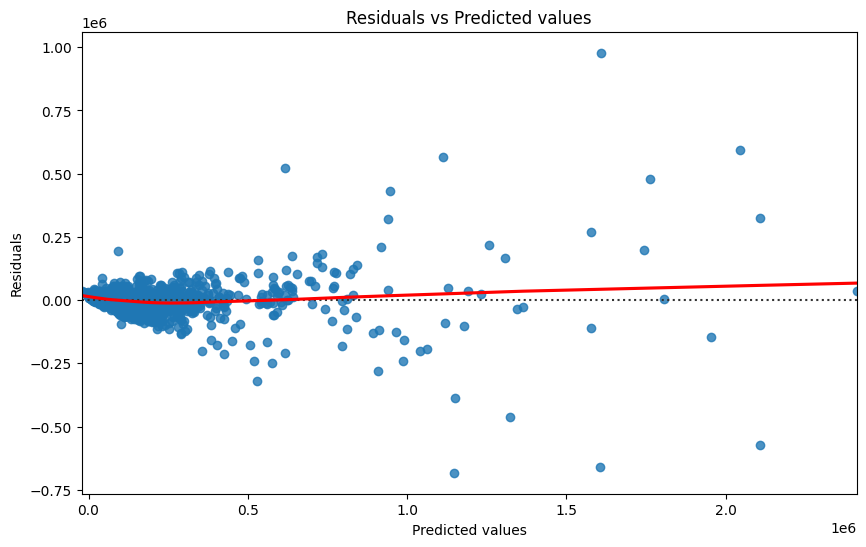

In [ ]:
import seaborn as sns

y_test_np = np.array(y_test)
y_pred_np = np.array(y_pred_ols)

residuals = y_test_np - y_pred_np



plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred_ols, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted values")
plt.show()


In [ ]:
lr_model = LinearRegression()

lr_model.fit(x_train, y_train)

y_pred_lr = lr_model.predict(x_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f"Linear Regression RMSE: {rmse_lr}")

Linear Regression RMSE: 40246.64393340695


The following exploration focuses on the MLP model. The two models presented here do not represent the best results; however, with parameter tuning, the MLP’s best outcome approaches that of decision trees and random forests.

In [ ]:
#mlp
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

numerical_cols = numerical

#  Target Encoding
x_numerical_and_target_encoded = pd.concat([x_2[numerical_cols], x_encoded[['model', 'category']]], axis=1)

scaler = MinMaxScaler()
x_normalized = scaler.fit_transform(x_numerical_and_target_encoded)


x_normalized_df = pd.DataFrame(x_normalized, columns=numerical_cols + ['model', 'category'])


x_final_1 = pd.concat([x_one_hot_df.reset_index(drop=True), x_normalized_df.reset_index(drop=True)], axis=1)

display(x_final_1)

,type_of_vehicle_hatchback,type_of_vehicle_luxury sedan,type_of_vehicle_mid-sized sedan,type_of_vehicle_mpv,type_of_vehicle_others,type_of_vehicle_sports car,type_of_vehicle_stationwagon,type_of_vehicle_suv,type_of_vehicle_truck,type_of_vehicle_van,...,curb_weight,power,engine_cap,no_of_owners,depreciation,dereg_value,omv,arf,model,category
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.057672,0.347202,0.156179,0.2,0.053634,0.092370,0.108262,0.092110,0.190898,0.029208
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.040995,0.139168,0.089397,0.2,0.032015,0.040188,0.048767,0.030651,0.084931,0.037086
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.048279,0.114778,0.113543,0.4,0.017740,0.014004,0.033119,0.021471,0.056255,0.052147
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.030249,0.060258,0.063257,0.4,0.013813,0.010577,0.018427,0.011207,0.024373,0.023199
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.048756,0.208034,0.156179,1.0,0.019671,0.007843,0.060777,0.038679,0.060517,0.023199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23504,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.031920,0.077475,0.063190,0.0,0.022757,0.028271,0.023296,0.013970,0.047710,0.037086
23505,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.042388,0.110473,0.063190,0.2,0.017608,0.027392,0.036851,0.021628,0.069636,0.052147
23506,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.038209,0.074605,0.063057,0.2,0.032213,0.010313,0.026831,0.009792,0.052457,0.044190
23507,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033433,0.067432,0.023414,0.2,0.021850,0.021244,0.027911,0.010646,0.044827,0.029208


In [ ]:
!pip install torch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

x_train, x_test, y_train, y_test = train_test_split(x_final_1, y, test_size=0.2, random_state=42)
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
# transform to torch
x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

#  MLP
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, input_size * 2)
        self.fc2 = nn.Linear(input_size * 2, input_size * 4)
        self.fc3 = nn.Linear(input_size * 4, input_size *2)
        self.fc4 = nn.Linear(input_size * 2, input_size )
        self.fc5 = nn.Linear(input_size, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x


input_size = x_train.shape[1]
model = MLP(input_size)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)


num_epochs = 1500
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


model.eval()
with torch.no_grad():
    y_pred_tensor = model(x_test_tensor)
    y_pred = y_pred_tensor.numpy()


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MLP Regressor RMSE (PyTorch): {rmse}")

Epoch [10/1500], Loss: 39896236032.0000
Epoch [20/1500], Loss: 39860932608.0000
Epoch [30/1500], Loss: 39536738304.0000
Epoch [40/1500], Loss: 37799628800.0000
Epoch [50/1500], Loss: 31780833280.0000
Epoch [60/1500], Loss: 22488645632.0000
Epoch [70/1500], Loss: 21304356864.0000
Epoch [80/1500], Loss: 19312396288.0000
Epoch [90/1500], Loss: 17183578112.0000
Epoch [100/1500], Loss: 15111756800.0000
Epoch [110/1500], Loss: 12504520704.0000
Epoch [120/1500], Loss: 9962440704.0000
Epoch [130/1500], Loss: 7786397184.0000
Epoch [140/1500], Loss: 6337134080.0000
Epoch [150/1500], Loss: 5293421568.0000
Epoch [160/1500], Loss: 4538036224.0000
Epoch [170/1500], Loss: 3977049600.0000
Epoch [180/1500], Loss: 3704159744.0000
Epoch [190/1500], Loss: 3396630784.0000
Epoch [200/1500], Loss: 3223708928.0000
Epoch [210/1500], Loss: 3067986944.0000
Epoch [220/1500], Loss: 2862725632.0000
Epoch [230/1500], Loss: 2739182336.0000
Epoch [240/1500], Loss: 2700315904.0000
Epoch [250/1500], Loss: 2615617024.000

In [ ]:

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, input_size * 2)
        self.fc2 = nn.Linear(input_size * 2, input_size)
        self.fc3 = nn.Linear(input_size, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


input_size = x_train.shape[1]
model_1 = MLP(input_size)


criterion = nn.MSELoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)

num_epochs = 2000
for epoch in range(num_epochs):
    model_1.train()
    optimizer.zero_grad()
    outputs = model_1(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


model_1.eval()
with torch.no_grad():
    y_pred_tensor = model_1(x_test_tensor)
    y_pred = y_pred_tensor.numpy()


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MLP Regressor RMSE (PyTorch): {rmse}")

Epoch [10/2000], Loss: 39891128320.0000
Epoch [20/2000], Loss: 39832154112.0000
Epoch [30/2000], Loss: 39615578112.0000
Epoch [40/2000], Loss: 39065350144.0000
Epoch [50/2000], Loss: 37945659392.0000
Epoch [60/2000], Loss: 36023713792.0000
Epoch [70/2000], Loss: 33178404864.0000
Epoch [80/2000], Loss: 29604603904.0000
Epoch [90/2000], Loss: 25925615616.0000
Epoch [100/2000], Loss: 23054147584.0000
Epoch [110/2000], Loss: 21515563008.0000
Epoch [120/2000], Loss: 20612808704.0000
Epoch [130/2000], Loss: 19737243648.0000
Epoch [140/2000], Loss: 18841626624.0000
Epoch [150/2000], Loss: 17960732672.0000
Epoch [160/2000], Loss: 17058006016.0000
Epoch [170/2000], Loss: 16122387456.0000
Epoch [180/2000], Loss: 15085091840.0000
Epoch [190/2000], Loss: 14048147456.0000
Epoch [200/2000], Loss: 12944988160.0000
Epoch [210/2000], Loss: 11941657600.0000
Epoch [220/2000], Loss: 10887291904.0000
Epoch [230/2000], Loss: 9923627008.0000
Epoch [240/2000], Loss: 9030770688.0000
Epoch [250/2000], Loss: 826